# 🚨 Please make a copy of this notebook before you start!
## Read the Cognite Learn content before running code examples.

##1. Environment Set Up
###Install the Cognite SDK package

In [ ]:
!pip install cognite-sdk>=6

### Connect to Cognite Data Fusion
This `client` object is how all queries will be sent to the Cognite API to retrieve or ingest data.

For `publicdata`, your user credentials are the same as you use to sign in to Cognite Hub and Cognite Learn. Here's how you do it

In [2]:
from cognite.client import CogniteClient, ClientConfig
from cognite.client.credentials import OAuthDeviceCode

TENANT_ID = "48d5043c-cf70-4c49-881c-c638f5796997"
CLIENT_ID = "1b90ede3-271e-401b-81a0-a4d52bea3273"
BASE_URL = "https://api.cognitedata.com"

oauth_provider = OAuthDeviceCode(
    authority_url=f"https://login.microsoftonline.com/{TENANT_ID}",
    client_id=CLIENT_ID,
    scopes=[f"{BASE_URL}/.default"],
)
client = CogniteClient(
    ClientConfig(
        client_name="Cognite Academy: Intro to PySDK",
        base_url=BASE_URL,
        project="publicdata",
        credentials=oauth_provider,
    )
)


On our first call to CDF, we will be prompted to log in.

Let's trigger that now with a call to the token inspect endpoint (which shows us what we have access to in CDF). A message will pop up under the cell with a link and a code you must copy in order to log in. It looks something like this:

`Device code: To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code CXXXXXXXX to authenticate.
`

In [3]:
token_info = client.iam.token.inspect()  # 'iam' stands for: Identity and Access Management

# Print out CDF projects we have access to:
[project.url_name for project in token_info.projects]

Device code: To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code CHA4THGVD to authenticate.


['infield-training', 'cdf-fundamentals', 'de-transformations', 'publicdata']

##2. Retrieving a list of Assets

The command `client.assets.list(limit=5)` retrieves the first `limit` number of assets, and returns it as an `AssetList`.

In [ ]:
client.assets.list(limit=5)

,external_id,name,parent_id,parent_external_id,description,metadata,id,created_time,last_updated_time,root_id
0,WMT:23-TE-96116-04,23-TE-96116-04,3117826349444493,WMT:23-DB-9101,VRD - PH 1STSTGGEAR THRUST BRG OUT,"{'ELC_STATUS_ID': '1211', 'RES_ID': '525283', ...",702630644612,0,1659105542151,6687602007296940
1,WMT:23-TE-96148,23-TE-96148,8515799768286580,WMT:23-TT-96148,VRD - PH 1STSTG COMP SEAL GAS HTR,"{'ELC_STATUS_ID': '1211', 'RES_ID': '532924', ...",5156972057719,0,1659105542254,6687602007296940
2,WMT:23-YT-96117-01,23-YT-96117-01,3257705896277160,WMT:23-YE-96117-01,VRD - PH 1STSTGGEAR 1 JOURNBRG DE,"{'ELC_STATUS_ID': '1211', 'RES_ID': '446683', ...",8019487489463,0,1659105542348,6687602007296940
3,WMT:23-FI-96151,23-FI-96151,4239585628663887,WMT:23-FT-96151,SOFT TAG VRD - PH 1STSTG PRIM SEAL LEAK DE,"{'ELC_STATUS_ID': '1211', 'SOURCE_DB': 'workma...",9258567430091,0,1659105542441,6687602007296940
4,WMT:23-LT-92521,23-LT-92521,2069232457199305,WMT:23-LV-92521A,VRD - PH 1STSTGSUCTSCRUBBER LEVEL,"{'ELC_STATUS_ID': '1211', 'RES_ID': '523206', ...",12670864495024,0,1659105542519,6687602007296940


##Search for Assets##
The `client.assets.search()` function allows you to search by a specific property of the asset, including its name, description, etc.

In [ ]:
client.assets.search("compressor", limit=3)

,external_id,name,parent_id,parent_external_id,description,metadata,id,created_time,last_updated_time,root_id
0,WMT:23-1ST STAGE COMPRESSOR-PH,23-1ST STAGE COMPRESSOR-PH,4518112062673878,WMT:23-1ST STAGE COMPRESSION-PH,1ST STAGE COMPRESSOR ON PH,"{'ELC_STATUS_ID': '1211', 'SOURCE_DB': 'workma...",7372310232665628,0,1659105617493,6687602007296940
1,WMT:23-2ND STAGE COMPRESSOR-PH,23-2ND STAGE COMPRESSOR-PH,5786472304680477,WMT:23-2ND STAGE COMPRESSION-PH,2ND STAGE COMPRESSOR ON PH,"{'ELC_STATUS_ID': '1211', 'SOURCE_DB': 'workma...",4074033093163622,0,1659105584193,6687602007296940
2,WMT:23-1ST STAGE COMPRESSION-PH,23-1ST STAGE COMPRESSION-PH,6895991969886325,WMT:230900,1ST STAGE COMPRESSION ON PH,"{'ELC_STATUS_ID': '1211', 'SOURCE_DB': 'workma...",4518112062673878,0,1659105588987,6687602007296940


### Fuzzy Search by name
The search by name includes results that are similar in name, but not an exact match.

In [8]:
asset_name = "23-HA-9103"
assets = client.assets.search(name=asset_name)
assets[:3]

,external_id,name,parent_id,parent_external_id,description,metadata,id,created_time,last_updated_time,root_id
0,WMT:23-HA-9103,23-HA-9103,2513266419866445,WMT:23-XX-9105,VRD - 1ST STAGE SUCTION COOLER,"{'ELC_STATUS_ID': '1211', 'RES_ID': '531306', ...",2861239574637735,1970-01-01,2022-07-29 14:39:31.752,6687602007296940
1,WMT:23-CB-9103A,23-CB-9103A,2137557577165478,WMT:23-1ST STAGE COMP LUBE OIL SYS-PH,VRD - 1ST STAGE COMPRESSOR LUBE OIL FILTER A,"{'ELC_STATUS_ID': '1211', 'RES_ID': '746776', ...",8790823573167638,1970-01-01,2022-07-29 14:40:31.121,6687602007296940
2,WMT:23-CB-9103B,23-CB-9103B,2137557577165478,WMT:23-1ST STAGE COMP LUBE OIL SYS-PH,VRD - 1ST STAGE COMPRESSOR LUBE OIL FILTER B,"{'ELC_STATUS_ID': '1211', 'RES_ID': '746776', ...",379497117972793,1970-01-01,2022-07-29 14:39:06.960,6687602007296940


###Retrieve a specific asset
The `client.assets.retrieve()` interface provides the same information for one specific asset based on the provided ID or external ID.

In [ ]:
identifier = "WMT:23-HA-9103"
asset = client.assets.retrieve(external_id=identifier)
f"Name: {asset.name}, description: {asset.description}"

'Name: 23-HA-9103, description: VRD - 1ST STAGE SUCTION COOLER'

##3. Events


Like we did for assets, we can list events. We will not go more in depth on events here, but you can also filter and search for events.

In [ ]:
client.events.list(limit=3)

,start_time,type,subtype,description,asset_ids,id,last_updated_time,created_time
0,0,RULE_BROKEN,-MB9-77Z1a8Na44PygcZ,Rule Test rule broken.,[8477639309770579],51548960196,1598339792121,1598339792121
1,0,RULE_BROKEN,-MFVG1dWU2PmZxSTlUL5,Rule RTEST broken.,[3904753668320840],62559091828,1601804531590,1601804531590
2,0,RULE_BROKEN,-MFVG1dWU2PmZxSTlUL5,Rule RTEST broken.,[3904753668320840],66046655876,1598949247808,1598949247808


In [ ]:
client.events.retrieve(external_id="DWH.Primavera_task_2566535")

,value
external_id,DWH.Primavera_task_2566535
type,***
subtype,VAL
asset_ids,[4650652196144007]
source,akerbp-cdp
id,14724046590280
last_updated_time,1625756573530
created_time,1610996539692
sourceId,7112618453384108
lastUpdatedTime,2021-06-10 08:10:09.776


##4. Asset Hierarchy and Relationships

We will generate a list of all children of the main asset of interest. The main asset of interest is listed first, then the children are listed underneath in following rows.

In [ ]:
subtree = client.assets.retrieve_subtree(id=4650652196144007)
print(len(subtree))
subtree[:5]

1105


,external_id,name,parent_id,parent_external_id,description,metadata,id,created_time,last_updated_time,root_id
0,WMT:VAL,VAL,6687602007296940,WMT:Aker BP,Valhall plattform,"{'SOURCE_DB': 'workmate', 'SOURCE_TABLE': 'wma...",4650652196144007,0,1669108190548,6687602007296940
1,WMT:23,23,4650652196144007,WMT:VAL,GAS COMPRESSION AND RE-INJECTION (PH),"{'SOURCE_DB': 'workmate', 'SOURCE_TABLE': 'wma...",3111454725058294,0,1659105573617,6687602007296940
2,WMT:230900,230900,3111454725058294,WMT:23,GAS COMPRESSION AND RE-INJECTION ON PH,"{'ELC_STATUS_ID': '1211', 'SOURCE_DB': 'workma...",6895991969886325,0,1659105612482,6687602007296940
3,WMT:23-TT-92604B,23-TT-92604B,6895991969886325,WMT:230900,VRD - PH 1STSTGDISCCOOL COOLMED IN,"{'ELC_STATUS_ID': '1212', 'SOURCE_DB': 'workma...",1150715783816357,0,1659105553538,6687602007296940
4,WMT:23-1ST STAGE COMPRESSION-PH,23-1ST STAGE COMPRESSION-PH,6895991969886325,WMT:230900,1ST STAGE COMPRESSION ON PH,"{'ELC_STATUS_ID': '1211', 'SOURCE_DB': 'workma...",4518112062673878,0,1659105588987,6687602007296940


##5. Collecting Time Series Data

###Compile a list of time series objects under the asset
For each of the assets in the subtree we retrieved, we can get all the associated time series by using the `.time_series()` method. We then get a `TimeSeriesList` object back:

In [ ]:
all_timeseries = subtree.time_series()
print(len(all_timeseries),'time series in subtree')
all_timeseries[:5]

363 time series in subtree


,id,external_id,name,is_string,metadata,asset_id,is_step,description,security_categories,created_time,last_updated_time
0,12378169571900,pi:161021,VAL_23-YA-96118-02:Z.X.Value,False,"{'context2ndEntityMatchConfScore': '-1', 'comp...",3111454725058294,False,PH 1stStg Gear1 Journ BRG NDE,[],1593024714298,1678880577182
1,62243813742212,pi:161024,VAL_23-YA-96120-01:Z.X.Value,False,"{'context2ndEntityMatchConfScore': '-1', 'comp...",3111454725058294,False,PH 1stStg Gear2 Journ BRG DE,[],1593024714298,1678880577182
2,75475333173539,pi:160920,VAL_23-TT-96115-01:Z.X.Value,False,"{'context2ndEntityMatchConfScore': '-1', 'comp...",3111454725058294,False,PH 1stStg Gear Thrust BRG IN,[],1593024714298,1678880577182
3,75873560338797,pi:160574,VAL_23-LY-92529_SILch0_SC0_TYSP:VALUE,False,"{'context2ndEntityMatchConfScore': '-1', 'comp...",1081261865374641,False,PH (Profiler) Shutdown Channel 0 - Tube y Setp...,[],1593024714298,1678880577182
4,138649441615650,pi:160061,VAL_23_FT_92537_03:Z.X.Value,False,"{'context2ndEntityMatchConfScore': '-1', 'comp...",3111454725058294,False,PH 1stStgComp Flow,[],1593024714298,1678880577182


If you are curious about which asset a time series is linked to, you can retrieve more information on the asset by using the retrieve function. Note that the property is called `asset_id`, following typical python style (so called "snake case"), while `assetId` is used in the underlying API. The SDK translates these for you while "talking" with the API.

In [ ]:
client.assets.retrieve(id=all_timeseries[5].asset_id)

,value
external_id,WMT:23
name,23
parent_id,4650652196144007
parent_external_id,WMT:VAL
description,GAS COMPRESSION AND RE-INJECTION (PH)
id,3111454725058294
created_time,0
last_updated_time,1659105573617
root_id,6687602007296940
SOURCE_DB,workmate


###View datapoints for specific time series
Let's fetch some datapoints for a time series by specifying its external ID:

In [ ]:
client.time_series.data.retrieve(external_id="pi:160184", start="10d-ago", end="now", limit=10)

,pi:160184
2023-03-14 09:55:27.090,162779.187500
2023-03-14 09:55:37.094,152046.906250
2023-03-14 09:55:47.095,153677.250000
2023-03-14 09:55:57.096,167971.562500
2023-03-14 09:56:07.090,169195.406250
2023-03-14 09:56:18.113,175333.078125
2023-03-14 09:56:28.115,176622.625000
2023-03-14 09:56:38.115,174679.687500
2023-03-14 09:56:48.129,172250.125000
2023-03-14 09:56:58.129,172332.546875


##6. Use Cases of CDF Data

###Collect datapoints from CDF
The time series names are defined in the `in_ts_exids` and out_ts_exid lists below.

In [ ]:
in_ts_exids = ["pi:160182", "pi:160697", "pi:160882"]
out_ts_exid = "pi:160696"
ts_exids = [*in_ts_exids, out_ts_exid]
ts_exids

['pi:160182', 'pi:160697', 'pi:160882', 'pi:160696']

###Retrieve Data Points from CDF
Most object types in the Python SDK have a `to_pandas` method which converts the result to a pandas dataframe. For retrieving aggregates such as the average over each time period, you can use `client.time_series.data.retrieve_dataframe` to get a pandas dataframe directly.

In [ ]:
from datetime import datetime, timedelta, timezone

train_start_date = datetime(2018, 8, 1, tzinfo=timezone.utc)
train_end_date = train_start_date + timedelta(days=30)

datapoints_df = client.time_series.data.retrieve_dataframe(
    external_id=ts_exids,
    aggregates="average",
    granularity="1m",
    start=train_start_date,
    end=train_end_date,
    include_aggregate_name=False,
    uniform_index=True,
)
datapoints_df = datapoints_df.interpolate().dropna()
datapoints_df.head()

,pi:160182,pi:160697,pi:160882,pi:160696
2018-08-01 00:00:00,91120.918480,3.374376,44.184863,3.251437
2018-08-01 00:01:00,86259.975220,3.395966,44.232420,3.274299
2018-08-01 00:02:00,90750.665657,3.410101,44.161438,3.287578
2018-08-01 00:03:00,91948.525170,3.358822,43.986025,3.237081
2018-08-01 00:04:00,93779.111997,3.429458,43.797913,3.306391


###Visualize the Time Series Data
The bottom right plot is the output time series, while the other 3 are the inputs used to create an estimate for the output.

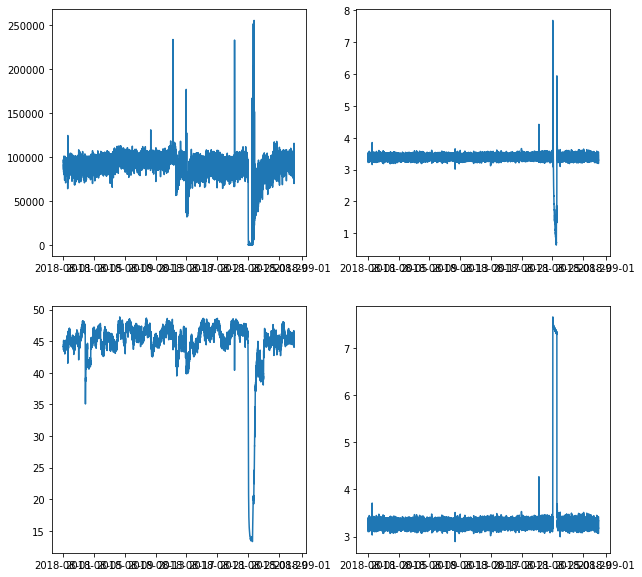

In [ ]:
import matplotlib.pyplot as plt

cols = datapoints_df.columns
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
for ax, col in zip(axes.flat, cols):
    ax.plot(datapoints_df[col])

# **Gathering Training Data**

In [ ]:
train_X = datapoints_df[in_ts_exids].to_numpy()
train_y = datapoints_df[out_ts_exid].to_numpy()

In [ ]:
train_X

array([[9.11209185e+04, 3.37437621e+00, 4.41848626e+01],
       [8.62599752e+04, 3.39596638e+00, 4.42324197e+01],
       [9.07506657e+04, 3.41010093e+00, 4.41614384e+01],
       ...,
       [1.09582724e+05, 3.19481165e+00, 4.42923385e+01],
       [1.01517415e+05, 3.19248060e+00, 4.45944329e+01],
       [9.55404161e+04, 3.29910375e+00, 4.48133932e+01]])

In [ ]:
train_y

array([3.25143706, 3.27429908, 3.28757847, ..., 3.06600563, 3.06770462,
       3.17634987])

In [ ]:
# Make the prediction on 1 hour of data:
to_predict_start = train_end_date
to_predict_end = train_end_date + timedelta(hours=1)
predict_df = client.time_series.data.retrieve_dataframe(
     external_id=ts_exids,
     aggregates="average",
     granularity="1m",
     start=to_predict_start,
     end=to_predict_end,
     include_aggregate_name=False,
     uniform_index=True,
 )
predict_df = predict_df.interpolate().dropna()
predict_df.head()

,pi:160182,pi:160697,pi:160882,pi:160696
2018-08-31 00:00:00,96596.397652,3.390761,44.822433,3.266866
2018-08-31 00:01:00,92941.748459,3.382212,44.879119,3.259393
2018-08-31 00:02:00,100634.003031,3.477319,45.053927,3.348573
2018-08-31 00:03:00,103948.895082,3.434556,45.404786,3.305596
2018-08-31 00:04:00,101079.342794,3.348590,45.698323,3.222974


# **Create a Basic Linear Regression Model**

The Mean Squared Error of our forecasts is: 0.0112
The R2 score of our forecasts is: -2.7307


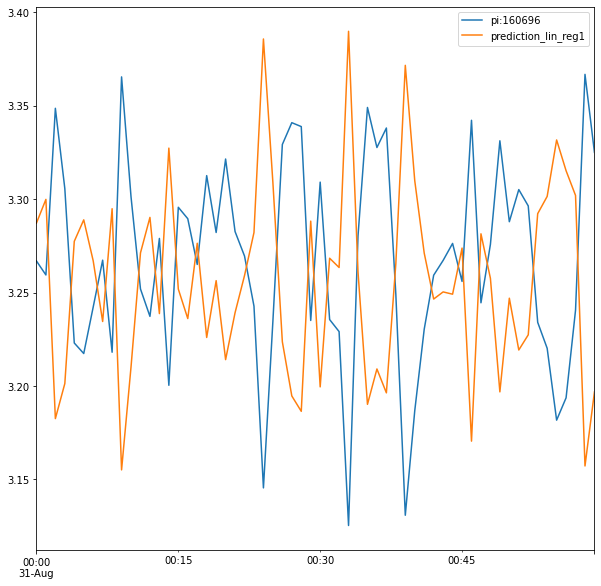

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

lin_reg = LinearRegression()
lin_reg.fit(train_X, train_y)

X = predict_df[in_ts_exids].to_numpy()
predict_df["prediction_lin_reg1"] = lin_reg.predict(X)

mse = mean_squared_error(predict_df[out_ts_exid], predict_df["prediction_lin_reg1"])
r2_s = r2_score(predict_df[out_ts_exid], predict_df["prediction_lin_reg1"])
print("The Mean Squared Error of our forecasts is:", round(mse, 4))
print("The R2 score of our forecasts is:", round(r2_s, 4))

predict_df.plot(y=[out_ts_exid, "prediction_lin_reg1"], figsize=(10, 10));

The Mean Squared Error on the training data is: 0.0112
The R2 score of our training data is: -2.7307


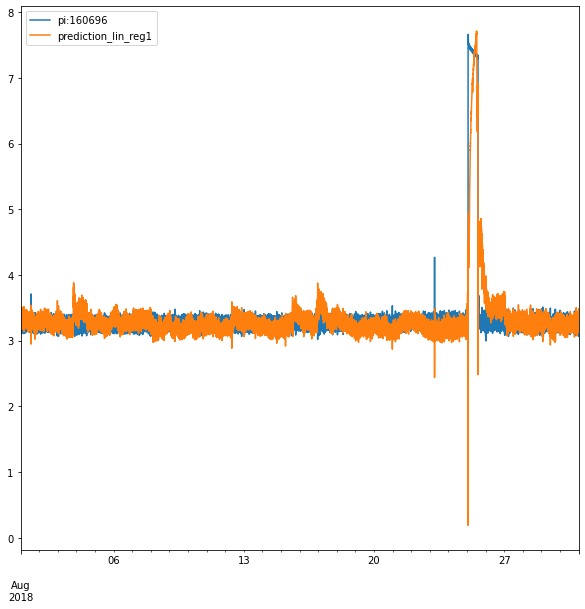

In [ ]:
# Look at the fit for the training data
X = datapoints_df[in_ts_exids].to_numpy()
datapoints_df["prediction_lin_reg1"] = lin_reg.predict(X)

mse = mean_squared_error(predict_df[out_ts_exid], predict_df["prediction_lin_reg1"])
r2_s = r2_score(predict_df[out_ts_exid], predict_df["prediction_lin_reg1"])
print("The Mean Squared Error on the training data is:", round(mse, 4))
print("The R2 score of our training data is:", round(r2_s, 4))

datapoints_df.plot(y=[out_ts_exid, "prediction_lin_reg1"], figsize=(10, 10));

# **Anomalous Period**

The Mean Squared Error of our forecasts is 0.0021
The R2 score of our forecasts is 0.2868


<Axes: >

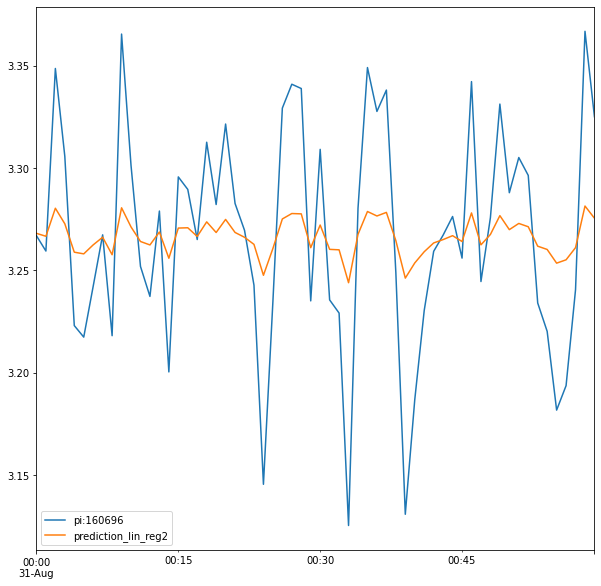

In [ ]:
import numpy as np

datapoints_df['state'] = (datapoints_df[out_ts_exid] < 4).astype(np.float64)
predict_df['state'] = (predict_df[out_ts_exid] < 4).astype(np.float64)

train_X2 = datapoints_df[in_ts_exids + ['state']].to_numpy()

lin_reg = LinearRegression()
lin_reg.fit(train_X2, train_y)
X = predict_df[in_ts_exids + ["state"]].to_numpy()
predict_df["prediction_lin_reg2"] = lin_reg.predict(X)

mse = mean_squared_error(predict_df[out_ts_exid], predict_df["prediction_lin_reg2"])
r2_s = r2_score(predict_df[out_ts_exid], predict_df["prediction_lin_reg2"])
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 4)))
print('The R2 score of our forecasts is {}'.format(round(r2_s, 4)))

predict_df.plot(y=[out_ts_exid, "prediction_lin_reg2"], figsize=(10, 10))

The Mean Squared Error on the training data is 0.0036
The R2 score of our training data is 0.9882


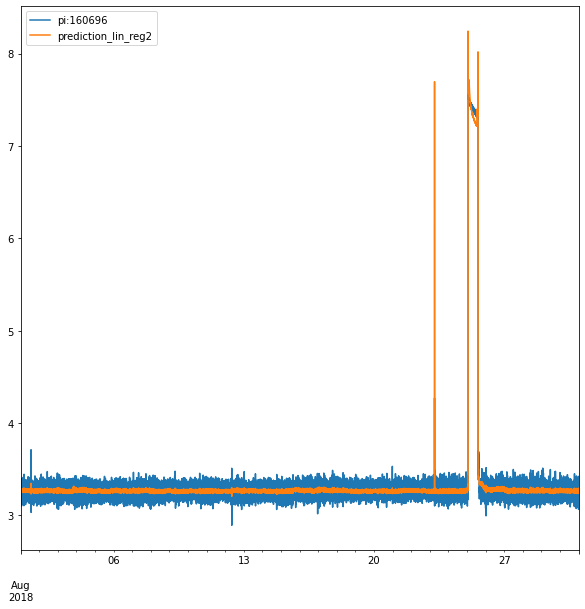

In [ ]:
# Look at the fit for the training data
# We see that adding the dummy feature approves the fit but it´s still not perfect.
lin_reg = LinearRegression()
lin_reg.fit(train_X2, train_y)

X = datapoints_df[in_ts_exids + ['state']].to_numpy()
datapoints_df["prediction_lin_reg2"] = lin_reg.predict(X)

mse = mean_squared_error(datapoints_df[out_ts_exid], datapoints_df["prediction_lin_reg2"])
r2_s = r2_score(datapoints_df[out_ts_exid], datapoints_df["prediction_lin_reg2"])
print('The Mean Squared Error on the training data is {}'.format(round(mse, 4)))
print('The R2 score of our training data is {}'.format(round(r2_s, 4)))

datapoints_df.plot(y=[out_ts_exid, "prediction_lin_reg2"], figsize=(10, 10));

# **Removing Outliers**

In [ ]:
import pandas as pd
quantiles = [0.95, 0.975, 0.98, 0.99]
quantiles_df = pd.DataFrame(
     {
          "quantile": quantiles,
          "value": np.quantile(datapoints_df[out_ts_exid], q=quantiles),
     }
)
quantiles_df

,quantile,value
0,0.950,3.371990
1,0.975,3.414761
2,0.980,3.498569
3,0.990,7.387688


#### Based on the quantiles, it seems we should cut-off values above 4:



In [ ]:
datapoints_df_adj = datapoints_df.loc[datapoints_df[out_ts_exid] < 4, :]
train_X_adj = datapoints_df_adj[in_ts_exids].to_numpy()
train_y_adj = datapoints_df_adj[out_ts_exid].to_numpy()

The Mean Squared Error of our forecasts is 2e-06
The R2 score of our forecasts is 0.999497


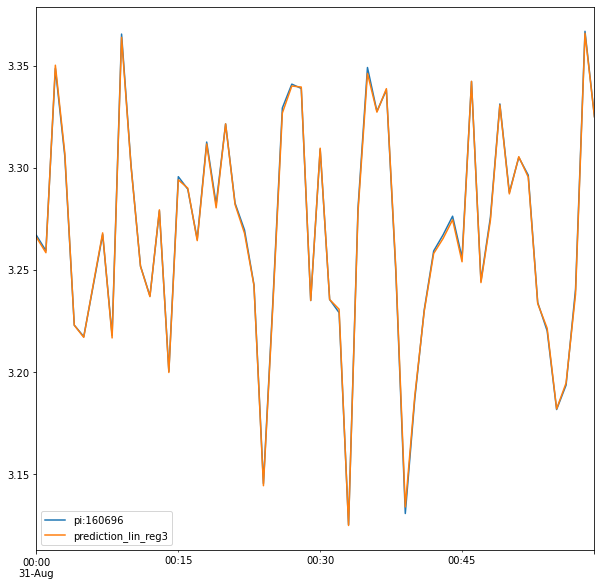

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(train_X_adj, train_y_adj)

X = predict_df[in_ts_exids].to_numpy()
predict_df["prediction_lin_reg3"] = lin_reg.predict(X)

mse = mean_squared_error(predict_df[out_ts_exid], predict_df["prediction_lin_reg3"])
r2_s = r2_score(predict_df[out_ts_exid], predict_df["prediction_lin_reg3"])
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 6)))
print('The R2 score of our forecasts is {}'.format(round(r2_s, 6)))

predict_df.plot(y=[out_ts_exid, "prediction_lin_reg3"], figsize=(10, 10));

The Mean Squared Error on the training data is 0.5932
The R2 score of our training data is -0.9573


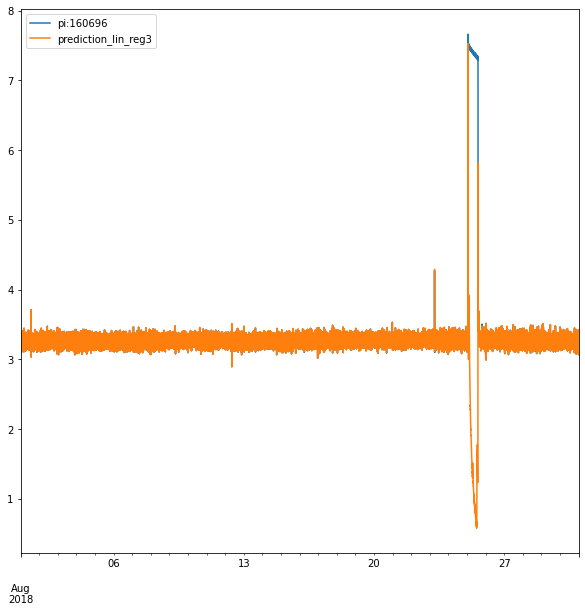

In [ ]:
# Look at the fit for the training data
lin_reg = LinearRegression()
lin_reg.fit(train_X_adj, train_y_adj)

X = datapoints_df[in_ts_exids].to_numpy()
datapoints_df["prediction_lin_reg3"] = lin_reg.predict(X)

mse = mean_squared_error(datapoints_df[out_ts_exid], datapoints_df["prediction_lin_reg3"])
r2_s = r2_score(datapoints_df[out_ts_exid], datapoints_df["prediction_lin_reg3"])
print('The Mean Squared Error on the training data is {}'.format(round(mse, 4)))
print('The R2 score of our training data is {}'.format(round(r2_s, 4)))

datapoints_df.plot(y=[out_ts_exid, "prediction_lin_reg3"], figsize=(10, 10));

# **Anomaly Detection** with Random Forest model

The Mean Squared Error of our forecasts is 0.0001.
The R2 score of our training data is 0.9563.


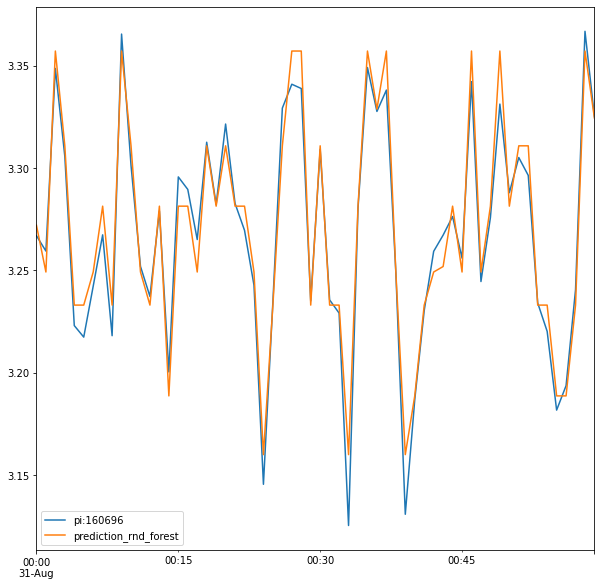

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rnd_forest_reg = RandomForestRegressor(n_estimators=10, min_samples_split=20, max_depth=5)
rnd_forest_reg.fit(train_X, train_y)

X = predict_df[in_ts_exids].to_numpy()
predict_df["prediction_rnd_forest"] = rnd_forest_reg.predict(X)

mse = mean_squared_error(predict_df[out_ts_exid], predict_df["prediction_rnd_forest"])
r2_s = r2_score(predict_df[out_ts_exid], predict_df["prediction_rnd_forest"])
print(f"The Mean Squared Error of our forecasts is {round(mse, 4)}.")
print(f"The R2 score of our training data is {round(r2_s, 4)}.")

predict_df.plot(y=[out_ts_exid, "prediction_rnd_forest"], figsize=(10, 10));

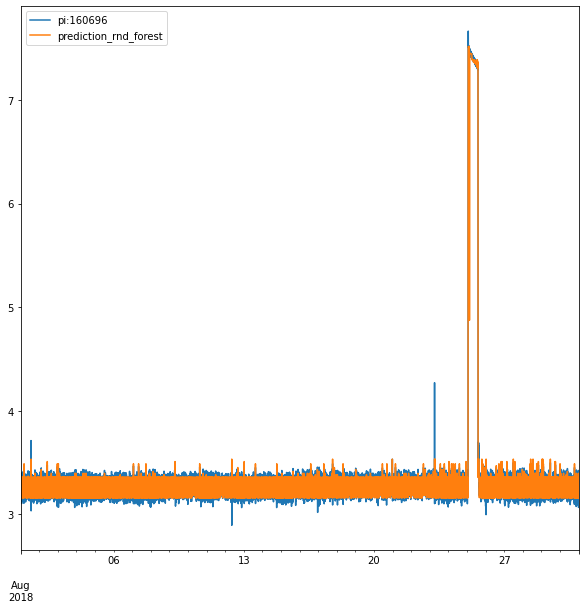

In [ ]:
# And let's check how it fares on the training data:
rnd_forest_reg = RandomForestRegressor(n_estimators=10, min_samples_split=20, max_depth=5)
rnd_forest_reg.fit(train_X, train_y)

X = datapoints_df[in_ts_exids].to_numpy()
datapoints_df["prediction_rnd_forest"] = rnd_forest_reg.predict(X)

datapoints_df.plot(y=[out_ts_exid, "prediction_rnd_forest"], figsize=(10, 10));

In [ ]:
# Train up until 100 timestamps before anomalous period
datapoints_df = datapoints_df.assign(
    datetime=datapoints_df.index
).reset_index(drop=True)

predict_start_index = min(datapoints_df[datapoints_df[out_ts_exid] > 5].index) - 100

datapoints_df_ad = datapoints_df.loc[:predict_start_index, :]
train_X = datapoints_df_ad[in_ts_exids].to_numpy()
train_y = datapoints_df_ad[out_ts_exid].to_numpy()

predict_df_ad = datapoints_df.loc[predict_start_index+1:, in_ts_exids + [out_ts_exid, "datetime"]]

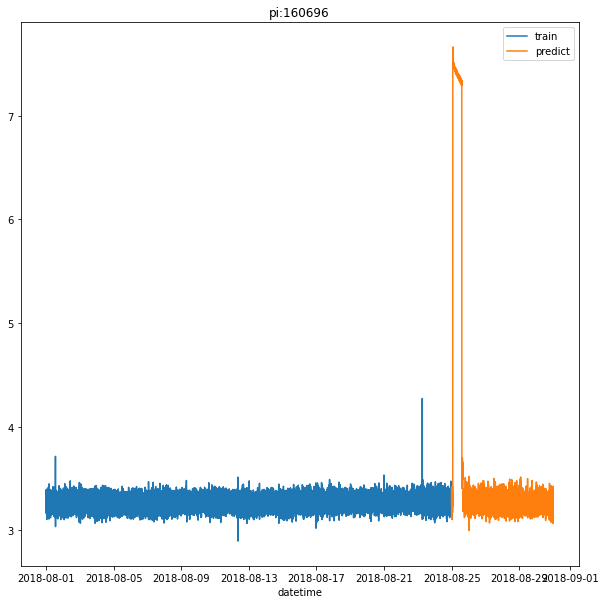

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(datapoints_df_ad["datetime"], datapoints_df_ad[out_ts_exid], label="train")
plt.plot(predict_df_ad["datetime"], predict_df_ad[out_ts_exid], label="predict")
plt.legend()
plt.xlabel("datetime")
plt.title(out_ts_exid);

In [ ]:
rnd_forest_reg = RandomForestRegressor(n_estimators=10, min_samples_split=20, max_depth=5)
rnd_forest_reg.fit(train_X, train_y)

X = predict_df_ad[in_ts_exids].to_numpy()
predict_df_ad["prediction_rnd_forest"] = rnd_forest_reg.predict(X)
predict_df_ad["residual"] = np.abs(predict_df_ad["prediction_rnd_forest"] - predict_df_ad[out_ts_exid])

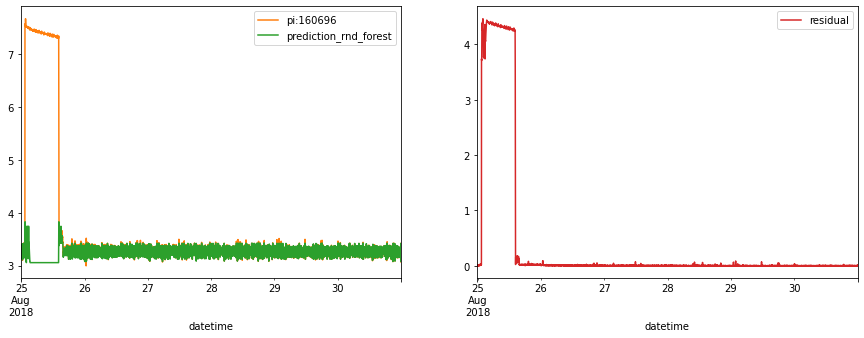

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
predict_df_ad.plot(
    x="datetime",
    y=[out_ts_exid, "prediction_rnd_forest"],
    ax=ax1,
    color=["C1", "C2"],
)
predict_df_ad.plot(
    x="datetime",
    y=["residual"],
    ax=ax2,
    color="C3",
);

# **Puzzle**

## Good luck! :D